In [ ]:
%matplotlib widget
from bmcs_shell.api import WBCell5ParamPhi, WBCell4Param
import numpy as np
import sympy as sp
sp.init_printing()

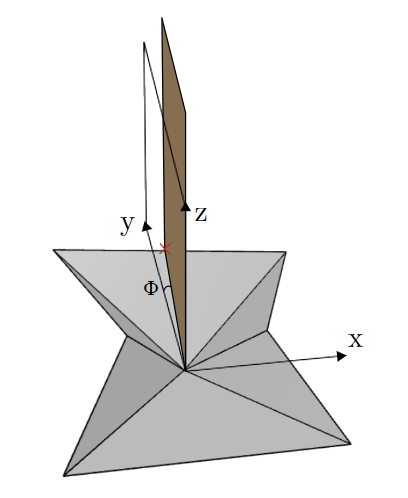

In [ ]:
wb_cell = WBCell5ParamPhi()
wb_cell.interact()

## Solving symbolically

In [ ]:
# 5 Params with phi

# Define coordinates
xl, yl, zl = sp.symbols('x_l y_l z_l', real=True)
xr, yr, zr = sp.symbols('x_r y_r z_r', real=True)
a, b, c, gamma, phi = sp.symbols('a b c gamma, phi', real=True, nonnegative=True)
t, t_l, t_r = sp.symbols('t, t_l, t_r', real=True)

O = sp.Matrix([0, 0, 0])
Ul_flat = sp.Matrix([-a, b, 0])
Ur_flat = sp.Matrix([a, b, 0])
Vl_flat = sp.Matrix([-c, 0, 0])
Vr_flat = sp.Matrix([c, 0, 0])

# Define vectors
Ul = sp.Matrix([xl, yl, zl])
Ur = sp.Matrix([xr, yr, zr])
Vl = sp.Matrix([-c * sp.sin(gamma), 0, c * sp.cos(gamma)])
Vr = sp.Matrix([c * sp.sin(gamma), 0, c * sp.cos(gamma)])

z = sp.Matrix([0, 0, 1])
y = sp.Matrix([0, 1, 0])
yz_plane_n = y.cross(z)
OUu_plane_n = ((Ur + Ul)/2).cross(z)

# Define unknowns
unknowns = [xl, yl, zl, xr, yr, zr]

# Define equations
eq1 = sp.simplify(Ur.norm()**2 - Ur_flat.norm()**2)
eq2 = sp.simplify(Ul.norm()**2 - Ul_flat.norm()**2)
eq3 = sp.simplify(Ul.dot(Ur) - Ul_flat.dot(Ur_flat)) # denominator was eleminated Ul.dot(Ur) / (Ul_flat.norm() * Ur_flat.norm()) as it's equal before and after folding
eq4 = sp.simplify(Ur.dot(Vr) - Ur_flat.dot(Vr_flat)) 
eq5 = sp.simplify(Ul.dot(Vl) - Ul_flat.dot(Vl_flat))
eq6 = sp.simplify(yz_plane_n.dot(OUu_plane_n)/(yz_plane_n.norm() * OUu_plane_n.norm()) - sp.cos(phi)) 

# sol = sp.solve([eq1, eq2, eq3, eq4, eq5, eq6], unknowns)
# sol

In [ ]:
eq1, eq2, eq3, eq4, eq5, eq6

In [ ]:
eq4

In [ ]:
zr_ = sp.solve(eq4, zr)[0]
zr_

In [ ]:
eq5

In [ ]:
zl_ = sp.solve(eq5, zl)[0]
zl_

In [ ]:
eq1 = eq1.subs({zr:zr_})
eq1

In [ ]:
xr_sqrt_pos = True
xr_ = sp.solve(eq1, xr)
xr_ = xr_[1] if xr_sqrt_pos else xr_[0]
xr_

In [ ]:
eq2 = eq2.subs({zl:zl_})
eq2

In [ ]:
xl_sqrt_pos = False
xl_ = sp.solve(eq2, xl)
xl_ = xl_[1] if xl_sqrt_pos else xl_[0]
xl_

In [ ]:
eq3 = eq3.subs({zr:zr_, zl:zl_})
eq3 = eq3.subs({xr:xr_, xl:xl_})
eq3

In [ ]:
t_l_ = sp.sqrt(b**2 - yl**2) * sp.cos(gamma)
t_r_ = sp.sqrt(b**2 - yr**2) * sp.cos(gamma)
t_ = a * sp.sin(gamma)

In [ ]:
eq3_new = eq3.subs({t_l_: t_l, t_r_: t_r, t_: t})
eq3_new

In [ ]:
# xl_sqrt_pos = True
yl_ = sp.solve(eq3_new, yl)[0]
yl_

In [ ]:
eq6 = eq6.subs({xl: xl_, xr: xr_})
eq6

In [ ]:
eq6_new = eq6.subs({t_l_: t_l, t_r_: t_r})
eq6_new

In [ ]:
sol = sp.solve([eq3_new, eq6_new], [yl, yr])
sol

In [ ]:
eq6

In [ ]:
eq6_reduced = sp.cse(eq6, ignore=(yl, yr))
eq6 = eq6_reduced[-1][0]
eq6

In [ ]:
eq3_reduced = sp.cse(eq3, ignore=(yl, yr))
eq3 = eq3_reduced[-1][0]
eq3

In [ ]:
eq3

In [ ]:
sol = sp.solve([eq3, eq6], [yl, yr])
sol

## Solving numerically

In [ ]:
from scipy.optimize import fsolve

# Define the values
a = 1000
b = 1000
c = 1000
gamma = np.pi/4
phi = np.pi/6


# Define a function that takes the unknowns as input and returns the equations as a numpy array
def equations(vars):
    xr, yr, zr, xl, yl, zl = vars

    z = np.array([0, 0, 1])

    Ur_flat = np.array([a, b, 0])
    Ul_flat = np.array([-a, b, 0])
    Vr_flat = np.array([c, 0, 0])
    Vl_flat = np.array([-c, 0, 0])

    Ul = np.array([xl, yl, zl])
    Ur = np.array([xr, yr, zr])
    Vl = np.array([-c * np.sin(gamma), 0, c * np.cos(gamma)])
    Vr = np.array([c * np.sin(gamma), 0, c * np.cos(gamma)])

    yz_plane_n = np.array([1, 0, 0])
    OUu_plane_n = np.cross((Ur + Ul) / 2, z)

    eq1 = np.linalg.norm(Ur) ** 2 - np.linalg.norm(Ur_flat) ** 2 # OU_ur is constant
    eq2 = np.linalg.norm(Ul) ** 2 - np.linalg.norm(Ul_flat) ** 2 # OU_ul is constant
    eq3 = np.dot(Ul, Ur) - np.dot(Ul_flat, Ur_flat) # angle (OU_ur, OU_ul) is constant
    eq4 = np.dot(Ur, Vr) - np.dot(Ur_flat, Vr_flat) # angle (OU_ur, OVr) is constant
    eq5 = np.dot(Ul, Vl) - np.dot(Ul_flat, Vl_flat) # angle (OU_ul, OVl) is constant
    # eq6: angle between plane yz and plane spanned with [0, 0, 1] with O((U_ur + U_ul)/2) is phi
    eq6 = np.dot(yz_plane_n, OUu_plane_n)/ (np.linalg.norm(yz_plane_n) * np.linalg.norm(OUu_plane_n)) - np.cos(phi)

    return np.array([eq1, eq2, eq3, eq4, eq5, eq6])

# Define initial guesses for the unknowns
x0 = np.array([a, a, a, -a, a, a])

# Call fsolve to solve the equations
sol = fsolve(equations, x0)

x_ur, y_ur, z_ur, x_ul, y_ul, z_ul = sol

if (phi > 0 and (x_ur + x_ul) / 2 < 0) or (phi < 0 and (x_ur + x_ul) / 2 > 0):
    x_ur, y_ur, z_ur, x_ul, y_ul, z_ul = -x_ul, y_ul, z_ul, -x_ur, y_ur, z_ur

# Print the solution
print('[xr,   yr,   zr, xl,   yl,   zl]')
print(x_ur, y_ur, z_ur, x_ul, y_ul, z_ul)